In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Оголосимо сталі параметри генераторів випадкових чисел

In [ ]:
SEED = 17

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data/diamonds.csv')

Оцінимо розміри датасету

In [ ]:
df.shape

(53940, 11)

Попередньо оглянемо

In [ ]:
df.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Видалимо непотрібний стовпець

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)

Оцінимо дані візуально.

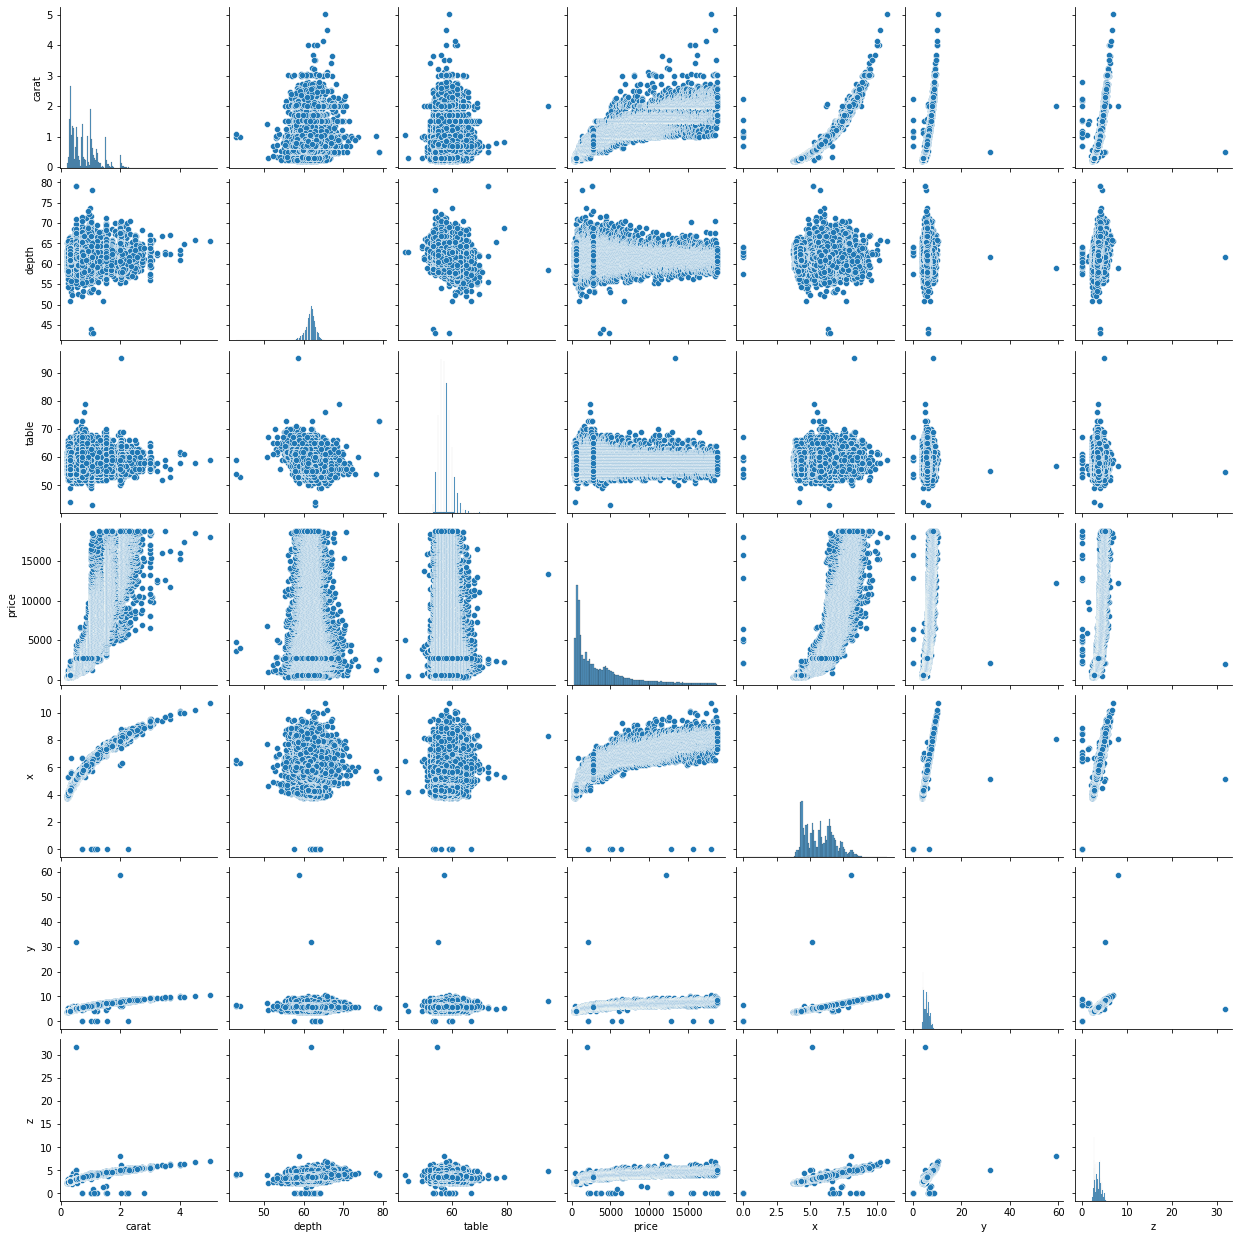

In [ ]:
sns.pairplot(df);

У даних присутні викиди, які варто прибрати. Розділимо для початку дані на категоріальні та кількісні.

In [ ]:
categorical_columns = [c for c in df.columns 
                             if df[c].dtype.name == 'object']

quantitative_columns = df.drop(categorical_columns, axis=1).columns.to_list()

In [ ]:
df1 = df.drop(categorical_columns, axis=1)
columns = df1.columns.to_list()

Усунемо викиди за формулою.

In [ ]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

df[columns] = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,NaN,Good,E,VS1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


Після усунення викидів у нас з'явились NaN. Заповнимо їх. Видалимо їх

In [ ]:
df = df.dropna()

Оцінимо результат.

In [ ]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

У стовпці Z залишились, що надто сильно виділяються. Усунемо їх.

In [ ]:
df = df.drop(df.nsmallest(2, 'z').index)

Оцінимо результат.

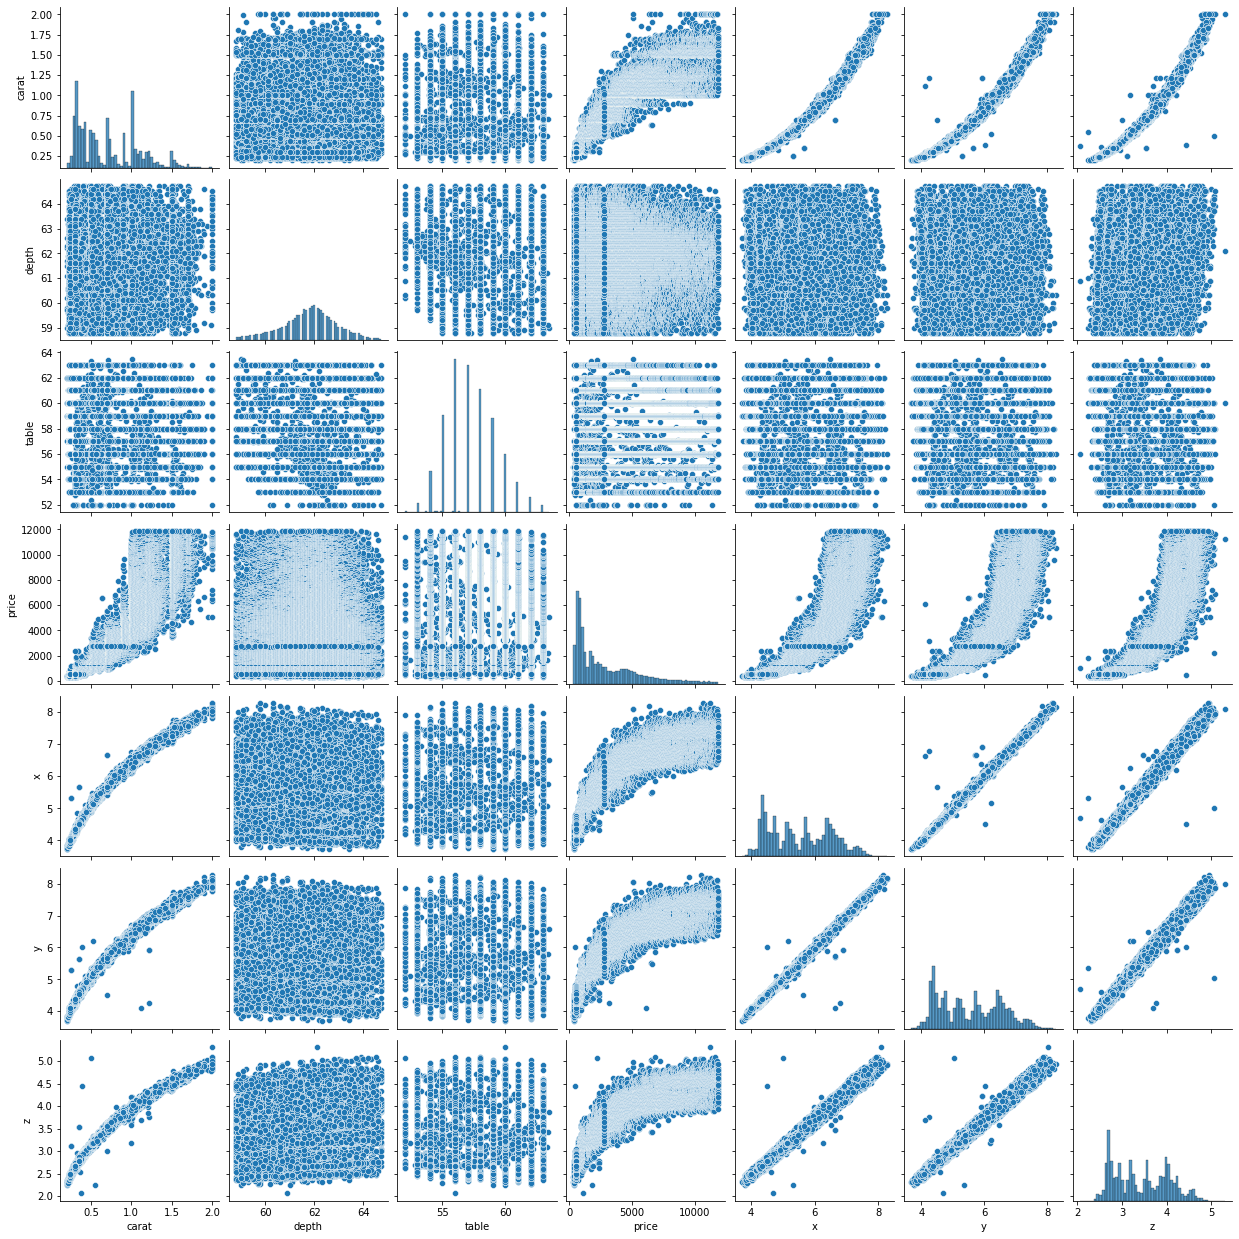

In [ ]:
sns.pairplot(df);

Займемось підготовкою датасетів для алгоритмів. Використаємо бустинг та нейронну мережі.

In [ ]:
target = df['price']
df = df.drop(['price'], axis=1)

In [ ]:
target.reset_index(drop=True, inplace=True)

In [ ]:
dt_df = df.copy()

In [ ]:
dt_df.reset_index(drop=True, inplace=True)
dt_df = pd.concat([dt_df, target], axis=1)

Закодуємо категоріальні змінні для бустингу.

In [ ]:
for c in categorical_columns:
    dt_df[c] = pd.factorize(df[c])[0]

In [ ]:
dt_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,0,0,0,61.5,55.0,3.95,3.98,2.43,326.0
1,0.21,1,0,1,59.8,61.0,3.89,3.84,2.31,326.0
2,0.29,1,1,2,62.4,58.0,4.20,4.23,2.63,334.0
3,0.31,2,2,0,63.3,58.0,4.34,4.35,2.75,335.0
4,0.24,3,2,3,62.8,57.0,3.94,3.96,2.48,336.0


In [ ]:
dt_train, dt_test = train_test_split(dt_df.values, test_size=0.3)

dt_train = pd.DataFrame(dt_train, columns = dt_df.columns)
dt_test = pd.DataFrame(dt_test, columns = dt_df.columns)

In [ ]:
xd_train = dt_train.drop(['price'], axis=1)
yd_train = dt_train['price']

xd_test = dt_test.drop(['price'], axis=1)
yd_test = dt_test['price']

Спочатку згодуємо наші дані в бустинг.

In [ ]:
params = {'seed': SEED}

In [ ]:
bst = lgb.LGBMRegressor(**params)
bst.fit(xd_train, yd_train)

LGBMRegressor(seed=17)

Оцінимо результат.

In [ ]:
lgb_pred = bst.predict(xd_test)
r2_score(yd_test, lgb_pred)

0.981917636123765

Також використаємо RandomForest для відбору ознак до нейронної мережі.

In [ ]:
rf = RandomForestRegressor(random_state = SEED)
rf.fit(xd_train, yd_train)

RandomForestRegressor(random_state=17)

In [ ]:
importances = pd.DataFrame({'feat': xd_train.columns,
                            'coef': rf.feature_importances_}).sort_values(by='coef', ascending=False)

In [ ]:
importances[importances['coef'] < 0.05]

,feat,coef
2,color,0.032042
6,x,0.021636
8,z,0.003869
4,depth,0.003132
5,table,0.002586
1,cut,0.002056


In [ ]:
df = df.drop(['depth', 'table', 'cut'], axis=1)

In [ ]:
df.dtypes

carat      float64
color       object
clarity     object
x          float64
y          float64
z          float64
dtype: object

Оновимо списки категоріальних та чисельних ознак, закодуємо їх.

In [ ]:
categorical_columns = [c for c in df.columns 
                             if df[c].dtype.name == 'object']

quantitative_columns = df.drop(categorical_columns, axis=1).columns.to_list()

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)

encoded_categorical = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical.columns = onehot_encoder.get_feature_names_out()

In [ ]:
scaler = MinMaxScaler()

encoded_numeric = pd.DataFrame(scaler.fit_transform(df[quantitative_columns]))
encoded_numeric.columns = scaler.get_feature_names_out()

In [ ]:
encoded_categorical.reset_index(drop=True, inplace=True)
encoded_numeric.reset_index(drop=True, inplace=True)

In [ ]:
linear_df = pd.concat([encoded_numeric, encoded_categorical, target], axis=1)

In [ ]:
linear_df.head()

,carat,x,y,z,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,0.016667,0.048352,0.065359,0.114198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,326.0
1,0.005556,0.035165,0.034858,0.077160,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,326.0
2,0.050000,0.103297,0.119826,0.175926,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,334.0
3,0.061111,0.134066,0.145969,0.212963,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,335.0
4,0.022222,0.046154,0.061002,0.129630,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,336.0


Розділимо нашу вибірку на навчальну та тестову.

In [ ]:
data_train, data_test = train_test_split(linear_df.values, test_size=0.3)

data_train = pd.DataFrame(data_train, columns = linear_df.columns)
data_test = pd.DataFrame(data_test, columns = linear_df.columns)

In [ ]:
X_train = data_train.drop(['price'], axis=1)
y_train = data_train['price']

X_test = data_test.drop(['price'], axis=1)
y_test = data_test['price']

In [ ]:
X_train.shape

(33265, 19)

Утворимо нейронну мережу

Додамо GPU.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


Опишемо її архітектуру - 2 приховані шари, в яких по 48 нейронів.

In [ ]:
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super(DenseNeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(19, 48),
            nn.PReLU(),
            nn.Linear(48, 48),
            nn.PReLU(),
            nn.Linear(48, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
dnn = DenseNeuralNetwork()

Перенесемо мережу на GPU.

In [ ]:
'''dnn.to(device)'''

'dnn.to(device)'

Оголосимо решту параметрів.

In [ ]:
criterion = nn.MSELoss()
optimizer = Adam(dnn.parameters(), lr=0.001)

batch_size = 1

x_train_tensor = torch.Tensor(X_train.values)
y_train_tensor = torch.Tensor(y_train.values)
x_test_tensor = torch.Tensor(X_test.values)
y_test_tensor = torch.Tensor(y_test.values)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Запустимо процес навчання.

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = dnn(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished Training


Задля оцінки результату перенесемо мережу назад на CPU

In [ ]:
'''cpu = torch.device('cpu')
dnn.to(cpu)'''

"cpu = torch.device('cpu')\ndnn.to(cpu)"

Оцінимо результат.

In [ ]:
y_train_pred = dnn(x_train_tensor).detach().numpy()
y_test_pred  = dnn(x_test_tensor).detach().numpy()

print('DNN test mse', mean_squared_error(y_test_tensor, y_test_pred))
print('DNN test r2', r2_score(y_test_tensor, y_test_pred))

DNN test mse 174875.28
DNN test r2 0.9764460251646336


Збережемо цю погань

In [ ]:
torch.save(dnn.state_dict(), 'cringe.pt')